# Project 3 : Hypothethis Testing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tpclean.tpclean as tp
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MinMaxScaler

In [2]:
!ls

LICENSE                      columns.csv
Music Genre by Education.png database.sqlite
MusicGenreRank_yp_pf.png     mod3_final_project.ipynb
Project_3.ipynb              out.png
README.md                    responses.csv
Unused Code.ipynb            yp_df.csv


In [3]:
tp.sql_connect("database.sqlite")

Connection to database.sqlite successfull. with curser <sqlite3.Cursor object at 0x1a1703e180>


In [4]:
db_tbls_df = tp.sql("select * from sqlite_master")

In [5]:
db_tables = {}
for tbl_name in db_tbls_df.tbl_name:
    db_tables[tbl_name] = tp.sql(f"SELECT * FROM {tbl_name}")

In [6]:
for key in db_tables.keys():
    print (f"{key}: {list(db_tables[key].columns)}")

reviews: ['reviewid', 'title', 'artist', 'url', 'score', 'best_new_music', 'author', 'author_type', 'pub_date', 'pub_weekday', 'pub_day', 'pub_month', 'pub_year']
artists: ['reviewid', 'artist']
genres: ['reviewid', 'genre']
labels: ['reviewid', 'label']
years: ['reviewid', 'year']
content: ['reviewid', 'content']


## Pitchfork Dataset

### Check for albums reviewed more than once

In [7]:

tp.sql("""SELECT COUNT(reviewid) as cnt, avg(score), * 
        FROM (SELECT * 
               FROM reviews 
               WHERE pub_year <2013) 
        GROUP BY (title)
        HAVING cnt > 1
        ORDER BY cnt DESC
        LIMIT 5""")

,cnt,avg(score),reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year
0,14,7.342857,17223,dj-kicks,hercules and love affair,http://pitchfork.com/reviews/albums/17223-dj-k...,7.0,0,tim finney,None,2012-10-22,0,22,10,2012
1,9,7.366667,16962,ii,nude beach,http://pitchfork.com/reviews/albums/16962-ii/,7.4,0,steven hyden,contributor,2012-08-09,3,9,8,2012
2,7,7.057143,13658,greatest hits,foo fighters,http://pitchfork.com/reviews/albums/13658-grea...,7.0,0,matthew perpetua,None,2009-11-03,1,3,11,2009
3,7,5.442857,16618,live,me,http://pitchfork.com/reviews/albums/16618-live/,7.3,0,tim finney,None,2012-05-16,2,16,5,2012
4,6,7.616667,10250,dj kicks,hot chip,http://pitchfork.com/reviews/albums/10250-dj-k...,8.0,0,mark pytlik,contributor,2007-05-23,2,23,5,2007


* Albums that have been reviewed more then once will get a avarage score over all thier reviews
* Data on Albums labeled as global or experimental will be excluded, becuase they dont have a counterpart in the young peoples Dataset

In [8]:
pf_df = tp.sql("""SELECT *
          FROM 
               (SELECT avg(score) as album_score, * 
                FROM reviews
                WHERE pub_year <2013 
                GROUP BY (title))
          JOIN genres USING(reviewid)
          WHERE genre NOT IN('global','experimental')
          """)
pf_df.head()

,album_score,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,genre
0,7.5,17477,finally rich,chief keef,http://pitchfork.com/reviews/albums/17477-fina...,7.5,0,jayson greene,senior editor,2012-12-14,4,14,12,2012,rap
1,7.5,17487,tuna melt ep,a-trak,http://pitchfork.com/reviews/albums/17487-tuna...,7.5,0,miles raymer,contributor,2012-12-14,4,14,12,2012,rap
2,7.5,17487,tuna melt ep,a-trak,http://pitchfork.com/reviews/albums/17487-tuna...,7.5,0,miles raymer,contributor,2012-12-14,4,14,12,2012,electronic
3,8.0,17471,orbits,starkey,http://pitchfork.com/reviews/albums/17471-orbits/,8.0,0,nate patrin,contributor,2012-12-14,4,14,12,2012,electronic
4,4.8,17391,o.n.i.f.c.,wiz khalifa,http://pitchfork.com/reviews/albums/17391-onifc/,4.8,0,jordan sargent,None,2012-12-13,3,13,12,2012,rap


### Collect Data on avarage score by genre

In [9]:
# split into subsets for genres
def feature_split(df,split_feature):
    df_dict = {}
    splits = list(df[split_feature].value_counts().index)
    for split in splits:
        temp = df[df[split_feature] == split]
        df_dict[split] = temp
    return df_dict
df = pf_df
split_feature = "genre"
df_list = feature_split(df,split_feature)

In [10]:
pf_df.album_score.describe()

count    13868.000000
mean         6.906780
std          1.390099
min          0.000000
25%          6.287500
50%          7.200000
75%          7.800000
max         10.000000
Name: album_score, dtype: float64

In [11]:
#transform album_score from (0-10) to the young people score (1-5) for comparison
scaler = MinMaxScaler(feature_range = (1,5), copy = True)
scaler.fit(np.asarray(pf_df.album_score).reshape(-1, 1))
dfs=[]
for key in df_list.keys():
    transformed = scaler.transform(np.asarray(df_list[key]["album_score"]).reshape(-1,1))
    #df_list[key].loc[:,"album_score"] = transformed
    df_list[key]["mean"] = transformed
    dfs.append(df_list[key])
new_pf_df=pd.concat(dfs,axis = 0)

/Users/pietrassyk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/pietrassyk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/pietrassyk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

In [12]:
new_pf_df1 = new_pf_df[["genre","mean"]].groupby("genre").agg(["mean","count","std"])
pf_ns = new_pf_df1["mean"]["count"]

In [13]:
new_pf_df = new_pf_df.groupby("genre").mean().sort_values("album_score", ascending = True).reset_index()[["genre","mean"]]

In [14]:
# Average adjusted Scoring for Music Genres in the Pitchfork Dataset
new_pf_df

,genre,mean
0,pop/r&b,3.727555
1,metal,3.732195
2,rap,3.743891
3,electronic,3.751600
4,rock,3.763719
5,folk/country,3.865215
6,jazz,3.888034


In [15]:
#Rank
pf_agg = new_pf_df
pf_agg["rank"]=pf_agg.index+1
pf_agg = pf_agg.sort_values("rank", ascending = False)
pf_agg

,genre,mean,rank
6,jazz,3.888034,7
5,folk/country,3.865215,6
4,rock,3.763719,5
3,electronic,3.751600,4
2,rap,3.743891,3
1,metal,3.732195,2
0,pop/r&b,3.727555,1


## Young Peoples Study

In [16]:
# young peoples study
yp_df = pd.read_csv("responses.csv")
yp_description = pd.read_csv("columns.csv")

## Cleaning

In [17]:
# Nan Values
yp_df.isnull().sum().sum()

608

In [18]:
#Replace Nan with Median for Numerical Data and Mode for Nonnumerical Data
df = yp_df
values = {}
for col in df.columns:
    if df[col].dtype == "O":
        values[col] = df[col].mode()  
    else: 
        values[col] = df[col].median()
df.fillna(value = values, inplace = True);

In [19]:
#Check for Success
yp_df = df
yp_df.isnull().sum().sum()

37

In [20]:
#export
yp_df.to_csv("yp_df.csv")

# Hypothesis #1 Music Preferences in YP vs. Pitchfork

### Hypothethis declaration
+ H0: Music Preferences Ranks between the YP-Dataset and Pitchfork do not differ.
+ H1: Music Preferences Rnaks between the YP-Dataset and Pitchfork differ.

Hypothethis will be tested using Mann-Whitney test for rank comparison

### Avarage score by Genre

#### Preperating the Young Peoples Dataset

In [21]:
#Combine Folk and Country Column to match the Pitchfork Music Genres
yp_df["Folk, Country"] = (yp_df["Folk"]+yp_df["Country"])/2

In [22]:
# Setting Values for Renaming Colunmns to exactly match Music Genres
rename_dict = {"Rock": "rock" ,
               "Pop" : "pop/r&b",
               "Hiphop, Rap":"rap",
               "Swing, Jazz":"jazz",
               "Metal or Hardrock": "metal",
               "Techno, Trance":"electronic",
               "Folk, Country":"folk/country"} #old:new

In [23]:
# Only select Music Genres that are also in the Pitchfork Genres
yp_music_df = yp_df[['Swing, Jazz',"Folk, Country","Rock",'Techno, Trance','Hiphop, Rap','Metal or Hardrock',"Pop"]]



In [24]:
# Aggreagation
yp_agg = yp_music_df.agg(["mean","count"])
yp_agg = yp_agg.rename(rename_dict, axis = "columns").transpose()
yp_agg = yp_agg.sort_values(by="mean", ascending = True)
yp_agg = yp_agg.reset_index()
yp_agg = yp_agg.rename({"index":"genre"}, axis = "columns")

# Give each Genry a Rank according to mean. With highest Ranknumber = Highes Popularity
yp_agg["rank"] = list(range(1,len(yp_agg)+1))
yp_agg.sort_values("rank", ascending = False)

,genre,mean,count,rank
6,rock,3.763366,1010.0,7
5,pop/r&b,3.473267,1010.0,6
4,rap,2.910891,1010.0,5
3,jazz,2.761386,1010.0,4
2,metal,2.360396,1010.0,3
1,electronic,2.336634,1010.0,2
0,folk/country,2.204950,1010.0,1


### Merging Aggregations of YP and Pitchfork

In [25]:
agg = yp_agg.merge(pf_agg, on = "genre", suffixes=('_yp', '_pf')).sort_values("mean_yp", ascending = False)
agg = agg.set_index("genre")
agg.mean_pf=agg.mean_pf
agg

,mean_yp,count,rank_yp,mean_pf,rank_pf
genre,,,,,
rock,3.763366,1010.0,7,3.763719,5
pop/r&b,3.473267,1010.0,6,3.727555,1
rap,2.910891,1010.0,5,3.743891,3
jazz,2.761386,1010.0,4,3.888034,7
metal,2.360396,1010.0,3,3.732195,2
electronic,2.336634,1010.0,2,3.751600,4
folk/country,2.204950,1010.0,1,3.865215,6


In [26]:
pf_ns

genre
electronic      2921
folk/country     519
jazz             351
metal            621
pop/r&b          988
rap              987
rock            7481
Name: count, dtype: int64

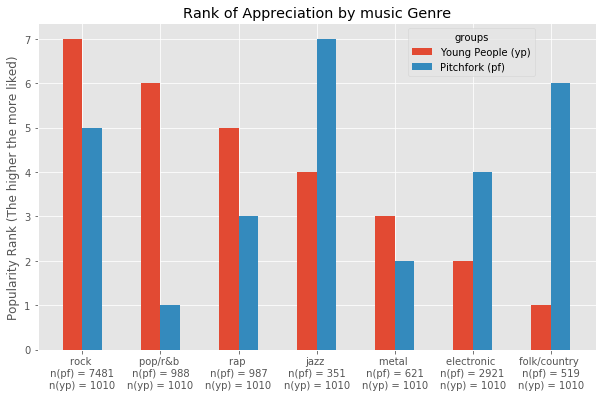

In [27]:
plt.style.use("ggplot")
fig = plt.figure(figsize = (10,6))
pos = np.asarray(list(range(7)))
plt.bar(pos - 0.125,agg["rank_yp"],width=0.25)
plt.bar(pos + 0.125,agg["rank_pf"], width=0.25)
plt.xticks(pos, [f"{genre} \n n(pf) = {pf_ns.loc[genre]} \nn(yp) = {len(yp_music_df)}" for genre in agg.index])
plt.title("Rank of Appreciation by music Genre")
plt.ylabel("Popularity Rank (The higher the more liked)")
plt.legend(title = "groups", loc = "upper right", labels = ["Young People (yp)","Pitchfork (pf)"], bbox_to_anchor=(0.9,1))
plt.show()

### Man-Whitney Test

In [28]:
yp_means = agg.mean_yp
pf_means = agg.mean_pf

In [29]:
stats.mannwhitneyu(yp_means,pf_means)

MannwhitneyuResult(statistic=4.0, pvalue=0.005301672691061329)

## Result

H0 can be rejected the Ranking of Pitchfork Users music preferences are different from the Young Students music Preferences

# Hypothesis #4 Music Type vs. Educational level
## Data Preperation

In [30]:
#Select Music-Genres from Dataset
yp_edu_df = yp_df[[
#'Music',
 'Dance',
 'Folk',
'Country',
'Classical music',
'Musical',
 'Pop',
 'Rock',
 'Metal or Hardrock',
 'Punk',
 'Hiphop, Rap',
 'Reggae, Ska',
 'Swing, Jazz',
 'Rock n roll',
 'Alternative',
 'Latino',
 'Techno, Trance',
 'Opera',
 #'Folk, Country',
 'Education']]

In [31]:
yp_edu_df.Education.value_counts()

secondary school                    621
college/bachelor degree             212
masters degree                       81
primary school                       80
currently a primary school pupil     10
doctorate degree                      5
Name: Education, dtype: int64

#### Primary School Pupils and Doctorates will be dropped, because of low sample sizes

In [32]:
yp_edu_df["Education"] = yp_edu_df.Education.apply(lambda x: "3 MA" if x== 'masters degree' else "2 BA" if x == 'college/bachelor degree' else "1 Highschool" if x == 'secondary school' else '0 Primary' if x =="primary school" else x  );


/Users/pietrassyk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [33]:
#Split into Relevant Groups
PS_df = yp_edu_df.loc[yp_edu_df.Education == '0 Primary' ]
HS_df = yp_edu_df.loc[yp_edu_df.Education == '1 Highschool' ]
BA_df = yp_edu_df.loc[yp_edu_df.Education == '2 BA' ]
MA_df = yp_edu_df.loc[yp_edu_df.Education == '3 MA' ]

#Aggregate
PS_agg = PS_df.agg(["std","mean"]).transpose().sort_values("mean", ascending = False)
HS_agg = HS_df.agg(["std","mean"]).transpose().sort_values("mean", ascending = False)
BA_agg = BA_df.agg(["std","mean"]).transpose().sort_values("mean", ascending = False)
MA_agg = MA_df.agg(["std","mean"]).transpose().sort_values("mean", ascending = False)


#Combine
yp_edu_df = pd.concat([PS_df,HS_df,BA_df,MA_df]) #TODO use split feature function instead

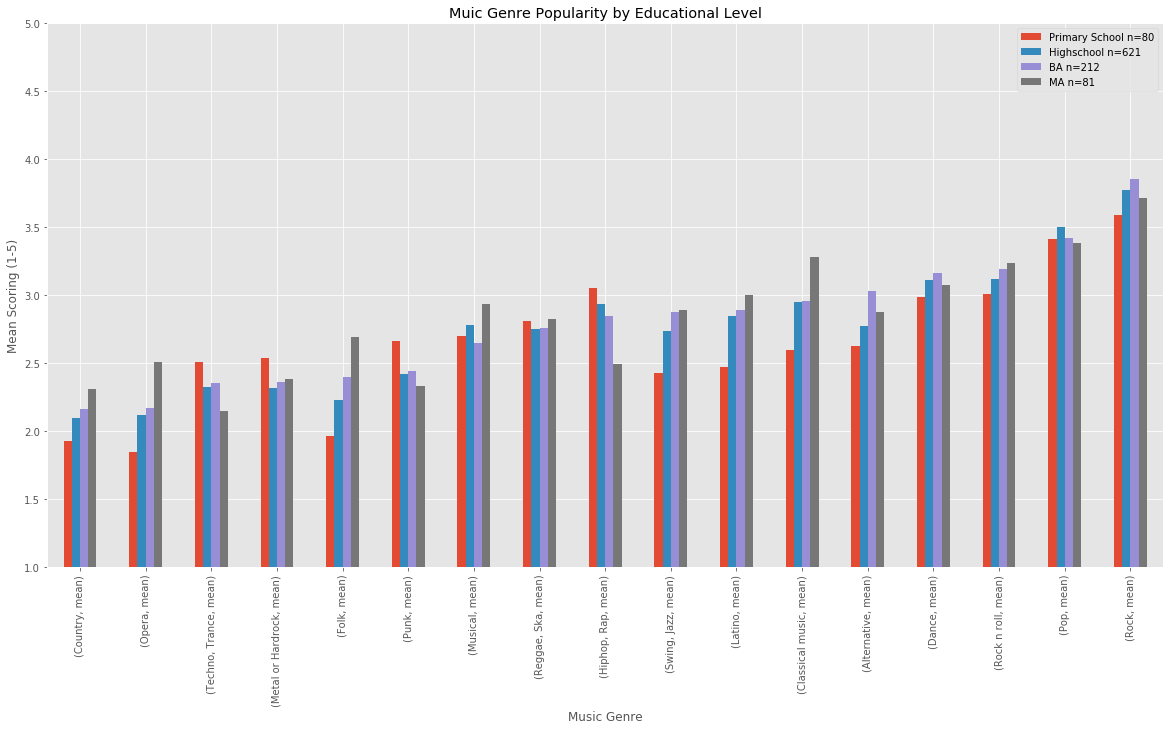

In [34]:
plt.style.use("ggplot")
plot_df = yp_edu_df.groupby("Education").agg(["mean"]).transpose().sort_values("2 BA")
plot_df.plot(kind = "bar", figsize = (20,10))
#plt.axhline(y = yp_edu_df.mean().mean(), ls = ":", label = "Avg Rating among Ratings")
plt.title("Muic Genre Popularity by Educational Level")
plt.ylabel("Mean Scoring (1-5)")
plt.ylim((1,5))
plt.xlabel("Music Genre")
plt.legend(labels = [f"Primary School n={len(PS_df)}",
                     f"Highschool n={len(HS_df)}",
                     f"BA n={len(BA_df)}" ,
                     f"MA n={len(MA_df)}" ]);

#TODO: Plot STD

## Hypothesis testing for Hypothesis #4

### MANOVA approach

A one way MANOVA was chosen, because the 17 target Variables(Music Genres) can be handled as numerical Data and there is only one predictor (Education) that can be handled categorically with 4 levels (PA,HS,BA,MA).

### Assumptions

#1 Obersvations are independant <br>
Study design description shows that Observations are independant 
see https://www.kaggle.com/miroslavsabo/young-people-survey for further information

In [35]:
#2 Dependant Variables are numerical
yp_edu_df.drop("Education" ,axis = 1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 994 entries, 11 to 1006
Data columns (total 17 columns):
Dance                994 non-null float64
Folk                 994 non-null float64
Country              994 non-null float64
Classical music      994 non-null float64
Musical              994 non-null float64
Pop                  994 non-null float64
Rock                 994 non-null float64
Metal or Hardrock    994 non-null float64
Punk                 994 non-null float64
Hiphop, Rap          994 non-null float64
Reggae, Ska          994 non-null float64
Swing, Jazz          994 non-null float64
Rock n roll          994 non-null float64
Alternative          994 non-null float64
Latino               994 non-null float64
Techno, Trance       994 non-null float64
Opera                994 non-null float64
dtypes: float64(17)
memory usage: 179.8 KB


In [36]:
#3 Independant Variable is Nomimanal

In [37]:
yp_edu_df.Education.dtype

dtype('O')

In [38]:
#4 Suffient Observations for each gruop in independant Variable (Education)
yp_edu_df.Education.value_counts()

1 Highschool    621
2 BA            212
3 MA             81
0 Primary        80
Name: Education, dtype: int64

In [39]:
#5 Linear Relationship between Dependant Variables
#sns.pairplot(yp_edu_df, hue = "Education", kind="reg" , plot_kwarg={"y_jitter": True, "x_jitter": True} )

In [40]:
#6 No Colinearity
#--> only a few correlations with a moderate value of r
yp_edu_df.drop("Education", axis = 1).corr().applymap(lambda x: x if abs(x)>0.5 else "")

,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,Punk,"Hiphop, Rap","Reggae, Ska","Swing, Jazz",Rock n roll,Alternative,Latino,"Techno, Trance",Opera
Dance,1,,,,,,,,,,,,,,,,
Folk,,1,,,,,,,,,,,,,,,
Country,,,1,,,,,,,,,,,,,,
Classical music,,,,1,,,,,,,,,,,,,0.593175
Musical,,,,,1,,,,,,,,,,,,
Pop,,,,,,1,,,,,,,,,,,
Rock,,,,,,,1,0.53479,0.515364,,,,,,,,
Metal or Hardrock,,,,,,,0.53479,1,0.549746,,,,,,,,
Punk,,,,,,,0.515364,0.549746,1,,,,,,,,
"Hiphop, Rap",,,,,,,,,,1,,,,,,,


In [41]:
#7 Homoscedasticity of dependant variables
# Check for Homoscedasticity using Levene
for key in PS_df.keys()[:-1]:
    p = stats.levene(PS_df[key],HS_df[key],BA_df[key],MA_df[key])[1]
    print(f"p-Value: {p} , homoscedastic ?: {p>0.05}")

p-Value: 0.09978590104286078 , homoscedastic ?: True
p-Value: 0.2980170955757283 , homoscedastic ?: True
p-Value: 0.4450621729039109 , homoscedastic ?: True
p-Value: 0.15340919728621966 , homoscedastic ?: True
p-Value: 0.4698476335244578 , homoscedastic ?: True
p-Value: 0.613330303906642 , homoscedastic ?: True
p-Value: 0.9519752917876482 , homoscedastic ?: True
p-Value: 0.6199296289729322 , homoscedastic ?: True
p-Value: 0.21618556372895117 , homoscedastic ?: True
p-Value: 0.9857748010481224 , homoscedastic ?: True
p-Value: 0.8215412338554305 , homoscedastic ?: True
p-Value: 0.5596460672520946 , homoscedastic ?: True
p-Value: 0.2508685208968258 , homoscedastic ?: True
p-Value: 0.835547567093836 , homoscedastic ?: True
p-Value: 0.5333536141347668 , homoscedastic ?: True
p-Value: 0.8277885291184616 , homoscedastic ?: True
p-Value: 0.16419868932755494 , homoscedastic ?: True


All assumption seem to be valid to use for MANOVA

### Testing

In [42]:
#Building a linear model for Manova
import statsmodels.multivariate.manova as sm

In [43]:
yp_edu_manova_df = yp_edu_df
yp_edu_manova_df["Edu"] = yp_edu_manova_df.Education.apply(lambda x: 0 if x =="0 Primary" else 1 if x=="1 Highschool" else 3 if x == "3 MA" else 2)
yp_edu_manova_df = yp_edu_manova_df.drop("Education", axis = 1)

In [44]:
yp_edu_manova_df.head()

,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,Punk,"Hiphop, Rap","Reggae, Ska","Swing, Jazz",Rock n roll,Alternative,Latino,"Techno, Trance",Opera,Edu
11,1.0,1.0,1.0,4.0,1.0,2.0,5.0,1.0,1.0,1.0,1.0,2.0,2.0,5.0,2.0,1.0,2.0,0
49,2.0,1.0,2.0,2.0,2.0,3.0,5.0,3.0,5.0,3.0,2.0,2.0,4.0,2.0,1.0,2.0,1.0,0
64,3.0,1.0,1.0,1.0,4.0,4.0,5.0,1.0,3.0,2.0,1.0,2.0,2.0,1.0,3.0,2.0,2.0,0
65,3.0,1.0,2.0,2.0,1.0,3.0,3.0,3.0,2.0,4.0,2.0,2.0,2.0,1.0,2.0,4.0,2.0,0
97,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,0


In [45]:
yp_edu_manova_df = yp_edu_manova_df.rename(lambda x: x.replace(",","").replace(" ","_").lower(), axis = "columns")

In [46]:
df = yp_edu_manova_df

In [47]:
#formula must contain dependant and independant Variables DV + DV... ~ IV ? <-- should work
DVs = df.columns[0:-1]
IVs = df.columns[-1]

formula = "+".join(DVs)+" ~ " + IVs
formula

'dance+folk+country+classical_music+musical+pop+rock+metal_or_hardrock+punk+hiphop_rap+reggae_ska+swing_jazz+rock_n_roll+alternative+latino+techno_trance+opera ~ edu'

In [48]:
mod = sm.MANOVA.from_formula(formula, data=df)
r = mod.mv_test()
print(r)

                   Multivariate linear model
                                                               
---------------------------------------------------------------
       Intercept        Value   Num DF  Den DF  F Value  Pr > F
---------------------------------------------------------------
          Wilks' lambda 0.1054 17.0000 976.0000 487.3519 0.0000
         Pillai's trace 0.8946 17.0000 976.0000 487.3519 0.0000
 Hotelling-Lawley trace 8.4887 17.0000 976.0000 487.3519 0.0000
    Roy's greatest root 8.4887 17.0000 976.0000 487.3519 0.0000
---------------------------------------------------------------
                                                               
---------------------------------------------------------------
           edu           Value   Num DF  Den DF  F Value Pr > F
---------------------------------------------------------------
           Wilks' lambda 0.9555 17.0000 976.0000  2.6730 0.0003
          Pillai's trace 0.0445 17.0000 976.0000  2.6730 0.

### Result
p-values in the MANOVA Matrix show that there are significant differences in Musical Preference between different education levels.


### Post-Hoc Testing
In the following sections 1 way ANOVAs are used to determine Music Genres that significantly change with Education level.

In [49]:
yp_edu_df.head()

,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,Punk,"Hiphop, Rap","Reggae, Ska","Swing, Jazz",Rock n roll,Alternative,Latino,"Techno, Trance",Opera,Education,Edu
11,1.0,1.0,1.0,4.0,1.0,2.0,5.0,1.0,1.0,1.0,1.0,2.0,2.0,5.0,2.0,1.0,2.0,0 Primary,0
49,2.0,1.0,2.0,2.0,2.0,3.0,5.0,3.0,5.0,3.0,2.0,2.0,4.0,2.0,1.0,2.0,1.0,0 Primary,0
64,3.0,1.0,1.0,1.0,4.0,4.0,5.0,1.0,3.0,2.0,1.0,2.0,2.0,1.0,3.0,2.0,2.0,0 Primary,0
65,3.0,1.0,2.0,2.0,1.0,3.0,3.0,3.0,2.0,4.0,2.0,2.0,2.0,1.0,2.0,4.0,2.0,0 Primary,0
97,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,0 Primary,0


In [50]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [51]:
#yp_edu_manova_df.edu = yp_edu_manova_df.edu.apply(lambda x: "PS" if x==0 else "HS" if x == 1 else "BA" if x ==2 else "MA")
yp_edu_manova_df.head()

,dance,folk,country,classical_music,musical,pop,rock,metal_or_hardrock,punk,hiphop_rap,reggae_ska,swing_jazz,rock_n_roll,alternative,latino,techno_trance,opera,edu
11,1.0,1.0,1.0,4.0,1.0,2.0,5.0,1.0,1.0,1.0,1.0,2.0,2.0,5.0,2.0,1.0,2.0,0
49,2.0,1.0,2.0,2.0,2.0,3.0,5.0,3.0,5.0,3.0,2.0,2.0,4.0,2.0,1.0,2.0,1.0,0
64,3.0,1.0,1.0,1.0,4.0,4.0,5.0,1.0,3.0,2.0,1.0,2.0,2.0,1.0,3.0,2.0,2.0,0
65,3.0,1.0,2.0,2.0,1.0,3.0,3.0,3.0,2.0,4.0,2.0,2.0,2.0,1.0,2.0,4.0,2.0,0
97,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,0


In [52]:
df = yp_edu_manova_df
sig_ANOVAs = []
for genre in df.columns[:-1]:
    formula = f"{genre}~C(edu)"
    lm = ols(formula,df).fit()
    table = sm.stats.anova_lm(lm,typ = 2)
    reject_h0 = table[table.columns[-1]][0]<0.025
    if reject_h0:
        sig_ANOVAs.append(genre)
    print(genre)
    print(table)
    print(f"REJECT H0?: {reject_h0}")
    print("")

dance
               sum_sq     df         F    PR(>F)
C(edu)       1.949197    3.0  0.475379  0.699491
Residual  1353.098087  990.0       NaN       NaN
REJECT H0?: False

folk
               sum_sq     df         F    PR(>F)
C(edu)      26.296018    3.0  6.888693  0.000136
Residual  1259.699958  990.0       NaN       NaN
REJECT H0?: True

country
               sum_sq     df         F    PR(>F)
C(edu)       6.569905    3.0  1.915959  0.125286
Residual  1131.584019  990.0       NaN       NaN
REJECT H0?: False

classical_music
               sum_sq     df         F   PR(>F)
C(edu)      18.844951    3.0  4.059981  0.00701
Residual  1531.739556  990.0       NaN      NaN
REJECT H0?: True

musical
               sum_sq     df         F    PR(>F)
C(edu)       5.745436    3.0  1.197914  0.309396
Residual  1582.746516  990.0       NaN       NaN
REJECT H0?: False

pop
               sum_sq     df         F    PR(>F)
C(edu)       2.038877    3.0  0.500783  0.681817
Residual  1343.555691  990.0  

In [53]:
print(sig_ANOVAs)

['folk', 'classical_music', 'opera']


## Result: 
The differenes in Folk, Classical Music and Opera are significant at a 5% confidence level amoungst different Educational Degrees